### Data loading

In [1]:
import trimap
import pandas as pd

In [ ]:
chronos = pd.read_csv("../data/CRISPR_gene_effect.csv",index_col=0)
chronos.columns = [c.split()[0].upper() + '_Chronos' for c in chronos.columns]
expression = pd.read_csv("../data/CCLE_expression.csv", index_col=0)
expression.columns = [c.split()[0].upper()+'_Expression' for c in expression.columns]
sample_info = pd.read_csv("../data/sample_info.csv", index_col=0)
ch_ex = chronos.merge(expression, right_index=True, left_index=True).dropna()

In [ ]:
id_to_name = {i:n for i, n in zip(sample_info.index, sample_info["stripped_cell_line_name"])}
name_to_id = {n:i for i, n in zip(sample_info.index, sample_info["stripped_cell_line_name"])}
name_to_lineage = {n:l for n, l in zip(sample_info["stripped_cell_line_name"], sample_info["lineage"])}
ch_ex.index = [id_to_name.get(n,n) for n in ch_ex.index]

### Scatter plots (Fig. S3a-b)

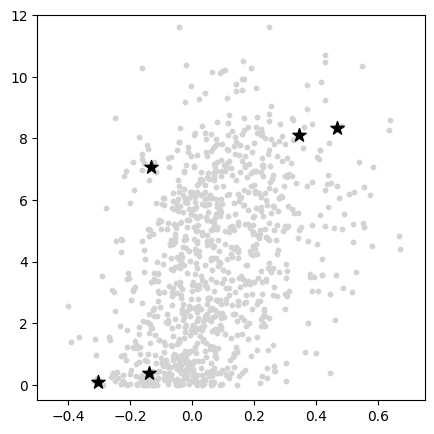

In [175]:
#Fig. S5a, b
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
x = 'TAOK1_Chronos'
y = 'CCN2_Expression'
cells = ['RPE1SS6','U2OS','MCF7','K562','PANC1']

plt.scatter(ch_ex[x],ch_ex[y],s=10,c='lightgray')
plt.scatter(ch_ex.loc[cells,x],ch_ex.loc[cells,y],s=100,c='black',marker='*')
plt.xlim((-0.5,0.75))
plt.ylim((-0.5,12))


plt.savefig('../result/figure.svg',dpi=300)

### Dimensionality reduction Optimization Fig.2c-e. S3a-b

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import networkx as nx
from sklearn.neighbors import kneighbors_graph

hippo_chr=['AMOTL2', 'KIRREL1', 'NF2', 'PDCD10', 'RNF146', 'TAOK1', 'PTPN14', 'MAP4K4', 'FRYL',  'LATS2',  'NRP1']
hippo_exp=['YAP1','WWTR1','CCN1','CCN2']
features = [gene + '_Chronos' for gene in hippo_chr] + [gene + '_Expression' for gene in hippo_exp] 
scaled_data = StandardScaler().fit_transform(ch_ex[features]) 

In [ ]:
#Modularity score
#Fig.S3b
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from sklearn.metrics.pairwise import rbf_kernel
import igraph as ig
import leidenalg as la

dimensionality_reduction_methods = {
    "UMAP": umap.UMAP(random_state=0, n_neighbors=6, min_dist=0.08),
    "PCA": PCA(n_components=2),
    "t-SNE": TSNE(n_components=2, random_state=0),
    "Trimap": trimap.TRIMAP(n_dims=2, n_outliers=10, n_inliers=10)
}

embeddings = {}
graphs = {}
results = []
for method_name, reducer in dimensionality_reduction_methods.items():
    print(method_name)
    embedding = reducer.fit_transform(scaled_data)
    scaled_embedding = StandardScaler().fit_transform(embedding)
    embeddings[method_name] = scaled_embedding
    W_rbf = rbf_kernel(scaled_embedding, gamma=5)
    W_rbf_symmetric = (W_rbf + W_rbf.T) / 2
    G_igraph = ig.Graph.Weighted_Adjacency(W_rbf_symmetric, mode='undirected')
    graphs[method_name] = G_igraph
    for r in range(1,21):
        r = r *0.1
        partition = la.find_partition(
            G_igraph,
            la.RBConfigurationVertexPartition,
            weights='weight',
            resolution_parameter=r,
            seed=0)

        leiden_labels = np.array(partition.membership)
        modularity = G_igraph.modularity(partition.membership, weights='weight')
        results.append([method_name, "Leiden Clustering", r, modularity])

df_results = pd.DataFrame(results, columns=["Dimensionality Reduction", "Clustering Method", "k", "Modularity Score"])
df_results.head()

UMAP


c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


PCA
t-SNE
Trimap


,Dimensionality Reduction,Clustering Method,k,Modularity Score
0,UMAP,Leiden Clustering,0.1,0.234484
1,UMAP,Leiden Clustering,0.2,0.539111
2,UMAP,Leiden Clustering,0.3,0.539455
3,UMAP,Leiden Clustering,0.4,0.540210
4,UMAP,Leiden Clustering,0.5,0.540392


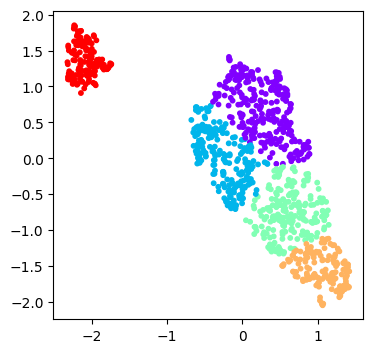

In [337]:
#Fig. S3a
r = 0.9
method = 'UMAP'
emb = embeddings[method]
G_igraph = graphs[method]
partition = la.find_partition(
        G_igraph,
        la.RBConfigurationVertexPartition,
        weights='weight',
        resolution_parameter=r,
        seed=0)

leiden_labels = np.array(partition.membership)
plt.figure(figsize=(4, 4))
plt.scatter(emb[:, 0], emb[:, 1], c=leiden_labels, s=10, cmap='rainbow')
plt.savefig('../result/figure.svg',dpi=300)
plt.show()

In [ ]:
#

### TriMAP visualization

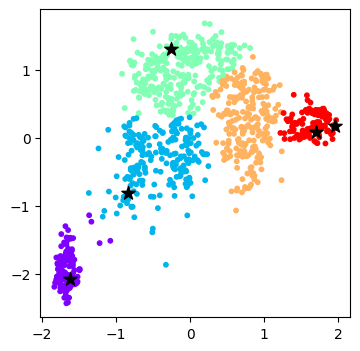

In [342]:
#Fig. 2c, s5d
embedding = pd.read_csv("../trimap_hippo.csv",index_col=0).values
emb = StandardScaler().fit_transform(embedding)
W_rbf = rbf_kernel(emb, gamma=5)
W_rbf_symmetric = (W_rbf + W_rbf.T) / 2
G_igraph = ig.Graph.Weighted_Adjacency(W_rbf_symmetric, mode='undirected')

r = 0.6
partition = la.find_partition(
        G_igraph,
        la.RBConfigurationVertexPartition,
        weights='weight',
        resolution_parameter=r,
        seed=0)

leiden_labels = np.array(partition.membership)
mapping = {4: 4, 2: 1, 1: 3, 0: 2, 3: 0}

updated_labels = [mapping[x] for x in leiden_labels]
plt.figure(figsize=(4, 4))
plt.scatter(emb[:, 0], emb[:, 1], c=updated_labels, s=10, cmap='rainbow')

cells = ['RPE1SS6','U2OS','MCF7','K562','PANC1']
cells_index = []
for cell in cells:
    cells_index.append(ch_ex.index.get_loc(cell))
plt.scatter(emb[cells_index, 0], emb[cells_index, 1], s=100, c='black', marker='*')

plt.savefig('../result/figure.svg', dpi=300)
plt.show()

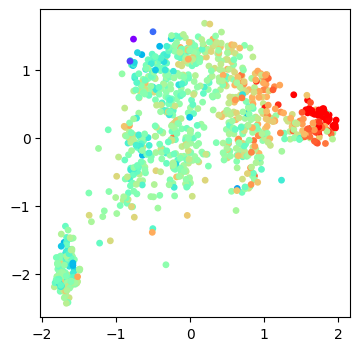

In [350]:
#Fig. 2d
plt.figure(figsize=(4,4))
plt.scatter(
    emb[:, 0],
    emb[:, 1], c=ch_ex['KIRREL1_Chronos'], cmap='rainbow', vmax=0.5, vmin=-0.5, s=15)


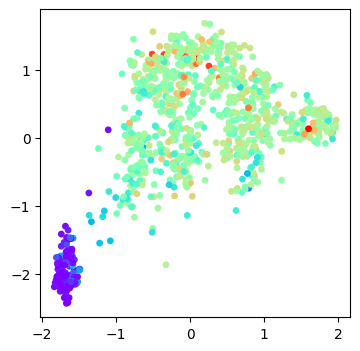

In [351]:
#Fig. 2e
plt.figure(figsize=(4,4))
plt.scatter(
    scaled_embedding[:, 0],
    scaled_embedding[:, 1], c=ch_ex['YAP1_Expression'], cmap='rainbow', vmax=10, vmin= 0, s=15)

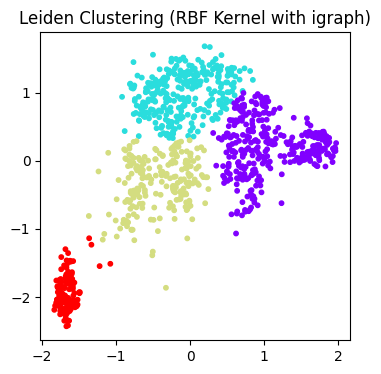

0.5,Modularity Score: 0.6362


In [334]:
for r in [0]:
    r = 0.5
    partition = la.find_partition(
        G_igraph,
        la.RBConfigurationVertexPartition,
        weights='weight',
        resolution_parameter=r,
        seed=0)

    leiden_labels = np.array(partition.membership)
    plt.figure(figsize=(4, 4))
    plt.scatter(scaled_embedding[:, 0], scaled_embedding[:, 1], c=leiden_labels, s=10, cmap='rainbow')
    plt.title("Leiden Clustering (RBF Kernel with igraph)")
    plt.savefig('../result/figure.svg',dpi=300)

    plt.show()

    modularity = G_igraph.modularity(partition.membership, weights='weight')
    print(f"{r},Modularity Score: {modularity:.4f}")

In [325]:
for r in [0]:
    r = 0.3
    partition = la.find_partition(
        G_igraph,
        la.RBConfigurationVertexPartition,
        weights='weight',
        resolution_parameter=r,
        seed=0)

    leiden_labels = np.array(partition.membership)
    mapping = {4: 4, 2: 1, 1: 3, 0: 2, 3: 0}

    updated_labels = [mapping[x] for x in leiden_labels]
    plt.figure(figsize=(4, 4))
    plt.scatter(scaled_embedding[:, 0], scaled_embedding[:, 1], c=updated_labels, s=10, cmap='rainbow')
    plt.title("Leiden Clustering (RBF Kernel with igraph)")
    plt.savefig('../result/figure.svg',dpi=300)

    plt.show()

    modularity = G_igraph.modularity(partition.membership, weights='weight')
    print(f"{r},Modularity Score: {modularity:.4f}")

KeyError: 27

In [266]:
modularity = partition.modularity
print(f"Modularity Score: {modularity:.4f}")

Modularity Score: 0.0008


In [275]:
modularity()

57117.32799068434

In [218]:
df_results.sort_values('Modularity Score', ascending=False).head(10)

,Dimensionality Reduction,Clustering Method,k,Modularity Score
30,Trimap,SpectralClustering,5,0.652752
31,Trimap,SpectralClustering,6,0.637867
32,Trimap,SpectralClustering,7,0.633510
23,t-SNE,SpectralClustering,7,0.620717
21,t-SNE,SpectralClustering,5,0.619488
22,t-SNE,SpectralClustering,6,0.617963
29,Trimap,SpectralClustering,4,0.617300
3,UMAP,SpectralClustering,5,0.611953
20,t-SNE,SpectralClustering,4,0.609282
33,Trimap,SpectralClustering,8,0.608227


c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


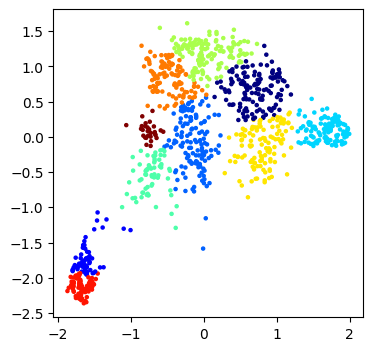

In [167]:
plt.figure(figsize=(4,4))
k = 10
a = embeddings['Trimap']
#embedding = pd.read_csv("../trimap_hippo.csv",index_col=0).values
#a = StandardScaler().fit_transform(embedding)
#labels = SpectralClustering(n_clusters=k, affinity='rbf', random_state=70, gamma = 10).fit_predict(a)
labels = SpectralClustering(n_clusters=k, affinity='precomputed', random_state=70).fit_predict(W)


plt.scatter(a[:, 0], a[:, 1], c=labels, cmap='jet', s=5)

c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


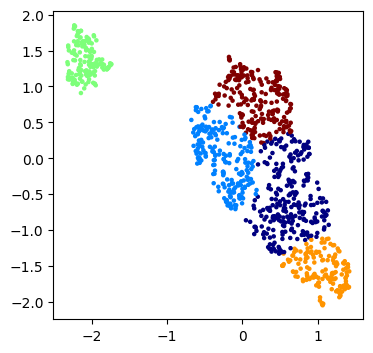

In [112]:
plt.figure(figsize=(4,4))
k = 5
a = embeddings['UMAP']

import numpy as np
import networkx as nx
from sklearn.neighbors import kneighbors_graph

# Build kNN graph (distances)
knn_graph = kneighbors_graph(
    a, 
    n_neighbors=100, 
    mode='distance', 
    include_self=False
)

# Convert distances to similarities using Gaussian kernel
sigma = np.mean(knn_graph.data)  # bandwidth
similarities = np.exp(- (knn_graph.data ** 2) / (2 * sigma ** 2))

# Replace distances with similarities
W = knn_graph.copy()
#W.data = similarities

# Build weighted graph
G = nx.from_scipy_sparse_array(W)

# Build spectral clustering with precomputed affinity
clustering = SpectralClustering(
    n_clusters=k,
    affinity='precomputed',
    random_state=70
)

# Fit on similarity matrix instead of raw features
labels = clustering.fit_predict(W)
plt.scatter(a[:, 0], a[:, 1], c=labels, cmap='jet', s=5)


In [164]:
df_results.sort_values('Modularity Score', ascending=False)[:30]

,Dimensionality Reduction,Clustering Method,k,Modularity Score
8,UMAP,SpectralClustering,10,0.846560
35,Trimap,SpectralClustering,10,0.836463
7,UMAP,SpectralClustering,9,0.832247
33,Trimap,SpectralClustering,8,0.831907
34,Trimap,SpectralClustering,9,0.830413
6,UMAP,SpectralClustering,8,0.825708
5,UMAP,SpectralClustering,7,0.818086
32,Trimap,SpectralClustering,7,0.816699
25,t-SNE,SpectralClustering,9,0.807866
26,t-SNE,SpectralClustering,10,0.805883


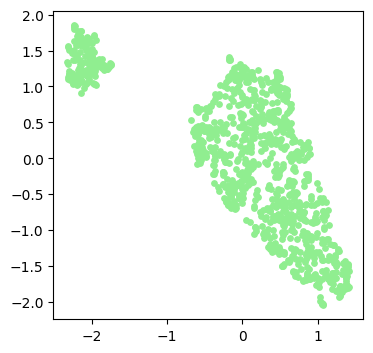

In [73]:
#Fig.S3a
method = 'UMAP'
plt.figure(figsize=(4,4))
plt.scatter(
    embeddings[method][:, 0],
    embeddings[method][:, 1], color='lightgreen', s=15)

### Leiden Clustering

In [219]:
df_results.to_csv('../result/modularity0902_rbf4.csv')

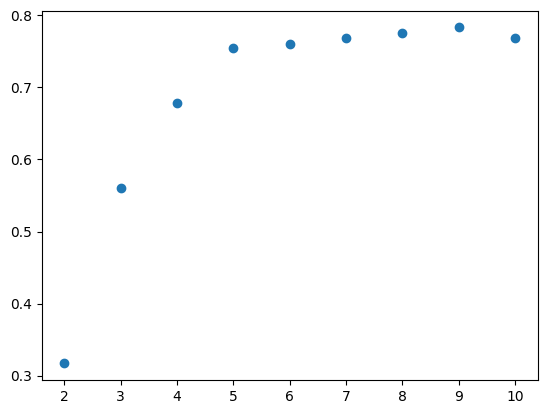

In [45]:
#Modularity score
results = []
for k in range(2,11):
    labels = SpectralClustering(n_clusters=k, affinity='rbf', random_state=70, gamma = 5).fit_predict(scaled_embedding)
    # Prepare community list from labels
    community_list = [set(np.where(labels == l)[0]) for l in np.unique(labels)]
    # Calculate modularity
    modularity_score = nx.algorithms.community.quality.modularity(G, community_list, weight='weight')
    results.append(modularity_score)
plt.scatter(range(2,11),results)


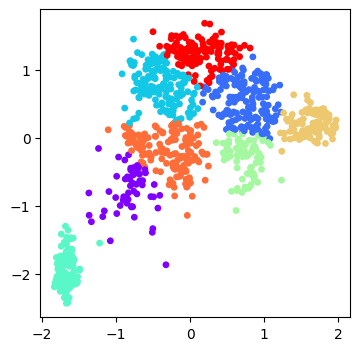

In [ ]:
#Modularity Fig.S3b
# 結果を保存するデータフレーム
results = []

# 次元削減ごとにループ
for method_name, reducer in dimensionality_reduction_methods.items():

    try:
        if isinstance(reducer, np.ndarray):
            embedding = reducer
        else:
            embedding = reducer.fit_transform(scaled_hippo1)

        scaled_embedding = StandardScaler().fit_transform(embedding)

    except Exception as e:
        print(f"{method_name} failed: {e}")
        continue

    # Spectral Clustering のみ適用
    for k in range(5,6):
        try:
            labels = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=70,n_neighbors=50).fit_predict(scaled_embedding)

            # k-NN グラフの作成
            knn_graph = kneighbors_graph(scaled_embedding, n_neighbors=50, mode='connectivity')
            G = nx.from_scipy_sparse_array(knn_graph)

            # クラスタ情報をコミュニティとして渡す
            communities = {i: [] for i in range(k)}
            for idx, label in enumerate(labels):
                communities[label].append(idx)
            communities = list(communities.values())

            # Modularity 計算
            modularity_score = nx.algorithms.community.modularity(G, communities)
            results.append([method_name, "SpectralClustering", k, modularity_score])
        except Exception as e:
            print(f"{method_name} with SpectralClustering (k={k}) failed: {e}")
            continue

# 結果をデータフレームに格納
df_results = pd.DataFrame(results, columns=["Dimensionality Reduction", "Clustering Method", "k", "Modularity Score"])


In [78]:
from sklearn.decomposition import PCA, FactorAnalysis, SparsePCA

cd = chronos.dropna()
reducer = FactorAnalysis(n_components=200,rotation='quartimax')
#reducer = SparsePCA(n_components=200)

embedding = reducer.fit_transform(cd)

In [31]:
from factor_analyzer import FactorAnalyzer

# fit the factor analysis
fa = FactorAnalyzer(n_factors=200, rotation='promax')
fa.fit(chronos.dropna())

# get the factor loadings
loadings = fa.loadings_

c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [79]:
emb_df = pd.DataFrame(embedding)

In [81]:
factor_loadings = reducer.components_.T

# Create a DataFrame for easy viewing
# Rows are your original features, columns are the new dimensions (factors)
loadings_df = pd.DataFrame(
    factor_loadings,
    index=cd.columns,
    columns=[f'Factor {i+1}' for i in range(reducer.n_components)]
)


In [83]:
emb_df.index = cd.index

In [75]:
emb_df.sort_values(94)[:13]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
YRDC_Chronos,-1.482085,5.473183,-2.781056,3.014443,-6.295951,-9.856319,3.750982,-0.032510,-10.083786,4.344971,...,5.126348,6.357750,3.315382,-3.497517,3.397958,4.454900,-0.191005,2.722651,-6.261340,-1.937811
MVK_Chronos,0.830666,0.745329,1.579260,2.750986,-0.551928,-3.453706,-1.261745,-1.058308,-6.798420,-0.108305,...,2.862043,-0.595562,2.576686,-5.086612,0.886721,2.719964,1.128126,-4.114260,-2.520721,-2.323310
SCAP_Chronos,-3.169503,2.660669,0.058990,4.022625,-0.162777,-2.792093,7.661201,-2.170334,-0.926508,2.279137,...,-3.803065,1.220314,1.876720,-0.570934,-2.500671,-1.781176,-9.479731,2.185289,-0.353513,5.094297
HMGCS1_Chronos,4.844181,0.265530,-1.996109,1.920019,-3.348326,-7.246774,0.529284,4.859516,-6.477987,1.863071,...,-2.709864,2.721951,5.861578,-5.323964,0.190517,1.511419,2.183609,-4.051838,0.871765,-2.949097
CCND1_Chronos,3.056108,2.911442,5.389644,-4.786500,5.635370,3.818801,1.609048,-0.104873,-8.689422,-2.676550,...,-4.157276,-2.570786,-0.638258,-2.874360,3.358543,-5.120981,6.552513,5.362602,-4.516660,-1.110172
SBDS_Chronos,2.235921,2.704349,-3.046755,0.675415,3.796100,1.083210,3.143643,0.944571,2.137190,0.937217,...,3.159417,-0.799335,4.937739,3.504477,-3.802054,-2.377350,2.023706,0.801024,3.341579,3.059740
URI1_Chronos,0.964826,5.872849,-1.495686,-0.266120,4.082705,-0.890569,-2.070807,2.030026,-1.997042,-1.253440,...,-0.829052,0.158079,3.925302,-3.339499,-1.593627,-2.006627,0.760934,1.879079,-1.325763,3.097710
PCBP1_Chronos,-1.061473,5.451669,1.711169,1.187598,2.425715,1.654553,4.152636,0.241993,4.472207,-1.585444,...,4.561093,-1.744931,0.796564,-1.100295,-0.766955,-3.374674,-1.239850,2.114822,1.494668,3.987245
TYMS_Chronos,-0.737728,0.667395,0.918456,3.259442,-1.708145,-4.765922,4.482512,-1.719234,-4.036658,4.807698,...,2.500341,9.902944,-2.008170,1.706783,-6.352247,-0.737389,6.274913,1.402957,-8.251450,1.397051
RIC1_Chronos,0.649455,0.118549,6.694035,1.177548,1.936768,-2.412289,1.706132,0.642408,0.614957,1.316469,...,-5.145234,0.292559,-6.296528,0.188155,3.069178,2.939478,2.222415,1.479569,4.393484,-2.291812


In [91]:
loadings_df.T.sort_values('TEDC1_Chronos')[['PLK4_Chronos','STIL_Chronos','SASS6_Chronos']]

,PLK4_Chronos,STIL_Chronos,SASS6_Chronos
Factor 11,-0.101262,-0.061820,-0.074317
Factor 6,-0.047909,-0.012419,-0.002614
Factor 4,0.010529,0.014882,0.003468
Factor 52,-0.014514,-0.017863,0.010620
Factor 111,-0.008795,-0.010918,-0.007636
...,...,...,...
Factor 8,0.031060,0.015709,0.004304
Factor 1,0.006188,-0.084311,-0.059598
Factor 106,0.017098,0.000612,0.001889
Factor 143,0.006026,-0.000522,0.004616


In [95]:
loadings_df.sort_values('Factor 6')[['Factor 6']][:30]

,Factor 6
NF2_Chronos,-0.135845
CFL1_Chronos,-0.133974
MED12_Chronos,-0.128897
NMT1_Chronos,-0.127396
MYBL2_Chronos,-0.118793
TAOK1_Chronos,-0.106857
SUPT20H_Chronos,-0.104374
TADA1_Chronos,-0.100389
STX4_Chronos,-0.099847
TADA2B_Chronos,-0.098812
